## Classify Emails beyond spams - using Hierarchical Clustering 

### This notebook shows the implementation of hierarchical clustering with WSD i.e. Word Sense Disambiguation. The synonyms and hypernyms have been included here. Level 3

### Final Project - Riti Chakraborty

In [1]:
#Riti Chakraborty
#importing the required libraries
import pandas as pd
import numpy as np
from numpy import nan

#For random seed
import random

#To handle warnings
import warnings
warnings.filterwarnings('ignore')

#library used for implementing hierarchical clustering 
import scipy

#For flattening lists
from itertools import chain

#For plotting data
import matplotlib.pyplot as plt


#library for tf-idf vector and other similarities measure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#For implementing Natural Language Processing approaches.
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

#For using Regular expression
import re

#For Handling Strings
import string


#For implementing word sense disambiguation
from nltk.corpus import wordnet as wn
from wordsegment import load, segment

#Important to call load()
load()

#For LDA Implementation # Importing Gensim
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora


#Libraries for hierarchical clustering
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from collections import defaultdict
from matplotlib.colors import rgb2hex
from matplotlib.colors import colorConverter


#For evaluation Topic models formed
from gensim.models import CoherenceModel

#For visualising LDA Output
import pyLDAvis
import pyLDAvis.gensim 

### Reading the file genrated from Project_Hierarchical_Clustering1.ipynb. It contains the semi preprocessed version of the data.

At each level the data set is varying with the addition of synonyms and hypernyms. Therefore, the advanced pre-processing steps have been repeated at each level.

In [2]:
#This file read here, has been generated by the data_preprocess.ipynb.
data_subset=pd.read_csv("../exported_tables/data_subset.csv")


#converting the data in the dataframe into str type
data_subset = data_subset.astype(str) 

#retaining proper index
data_subset=data_subset.reset_index(drop=True)

num_of_rows=len(data_subset.index)

# Converting each row to list of lists
list1=data_subset.values.tolist()
list2=[]

# Converting each sublist into string and storing it in list2
for i in range(0, len(list1)):
    list2.append(' '.join(map(str, list1[i])))

#converting each row into vectors #Printing the count of each term in the emails #Emails on Rows and Terms on columns
vectorizer1 = CountVectorizer()
row_vectors=vectorizer1.fit_transform(list2).todense()


### Defining function for stop word removal

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def stopword_remove(l2):
    fil_list2=[]
    for sent in l2:
        stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "spam","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
        word_tokens = word_tokenize(sent.lower())
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []

        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        fil_list2.append(' '.join(filtered_sentence))
    return fil_list2
fil_list2=stopword_remove(list2)

### Defining function for punctuation removal

In [4]:
#Function to remove punctuation
def no_punctuation(my_str):
    punctuations = '''!()-[]{};:'"\\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # returning the unpunctuated string
    return no_punct

### The function defined below deals with extraction and addition of synonyms from the wordnet API to the datset and segementation of words.

In [5]:
#Function for word segmentation and word sense disambiguation
def seg_syn(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        for s in pure_string:
            seg.append(segment(s))
    flat_seg_list = [item for sublist in seg for item in sublist]
    d = {'Term':[], 'Synonyms':[], 'Hypernyms':[]}
    d1={}
    syn0=[]
    hyp0=[]
    for f in flat_seg_list:
        d['Term'].append(f)        
        for syn in wn.synsets(f):
            synsets=syn
            for l in syn.lemmas():
                syn0.append(l.name())
                d1[f]=l.name()
                d['Synonyms'].append(l.name())

            for synset in synsets.hyponyms():
                for lemma in synset.lemmas():
                    d['Hypernyms'].append(lemma.name())
                    hyp0.append(lemma.name())
    return syn0,hyp0,flat_seg_list


In [6]:
#Storing the values returned from the function defined above.
list2_syn=[]
for l in fil_list2:

    #Storing the synonyms and the hypernyms part returned from the previous function
    syno,hypo,termz=seg_syn(str(l))
    list2_syn.append(syno+hypo+termz)     

#typecasting to string
flat_list2_syn=[]
for ls in list2_syn:
    flat_list2_syn.append(' '.join(list(set(ls))))

#Storing the final data as dataframe
df_flatlist=pd.DataFrame(flat_list2_syn)
df_flatlist["Index"]=df_flatlist.index

# Hierarchical Clustering

In [7]:
#Unsupervised Kmeans clustering
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(flat_list2_syn)

#Converting to Matrix form
X_matrix=X.todense()

#Terms in overall dataset
terms = vect.get_feature_names()

# Version 1
# H. Clustering using Ward Linkage and Euclidean distance metric

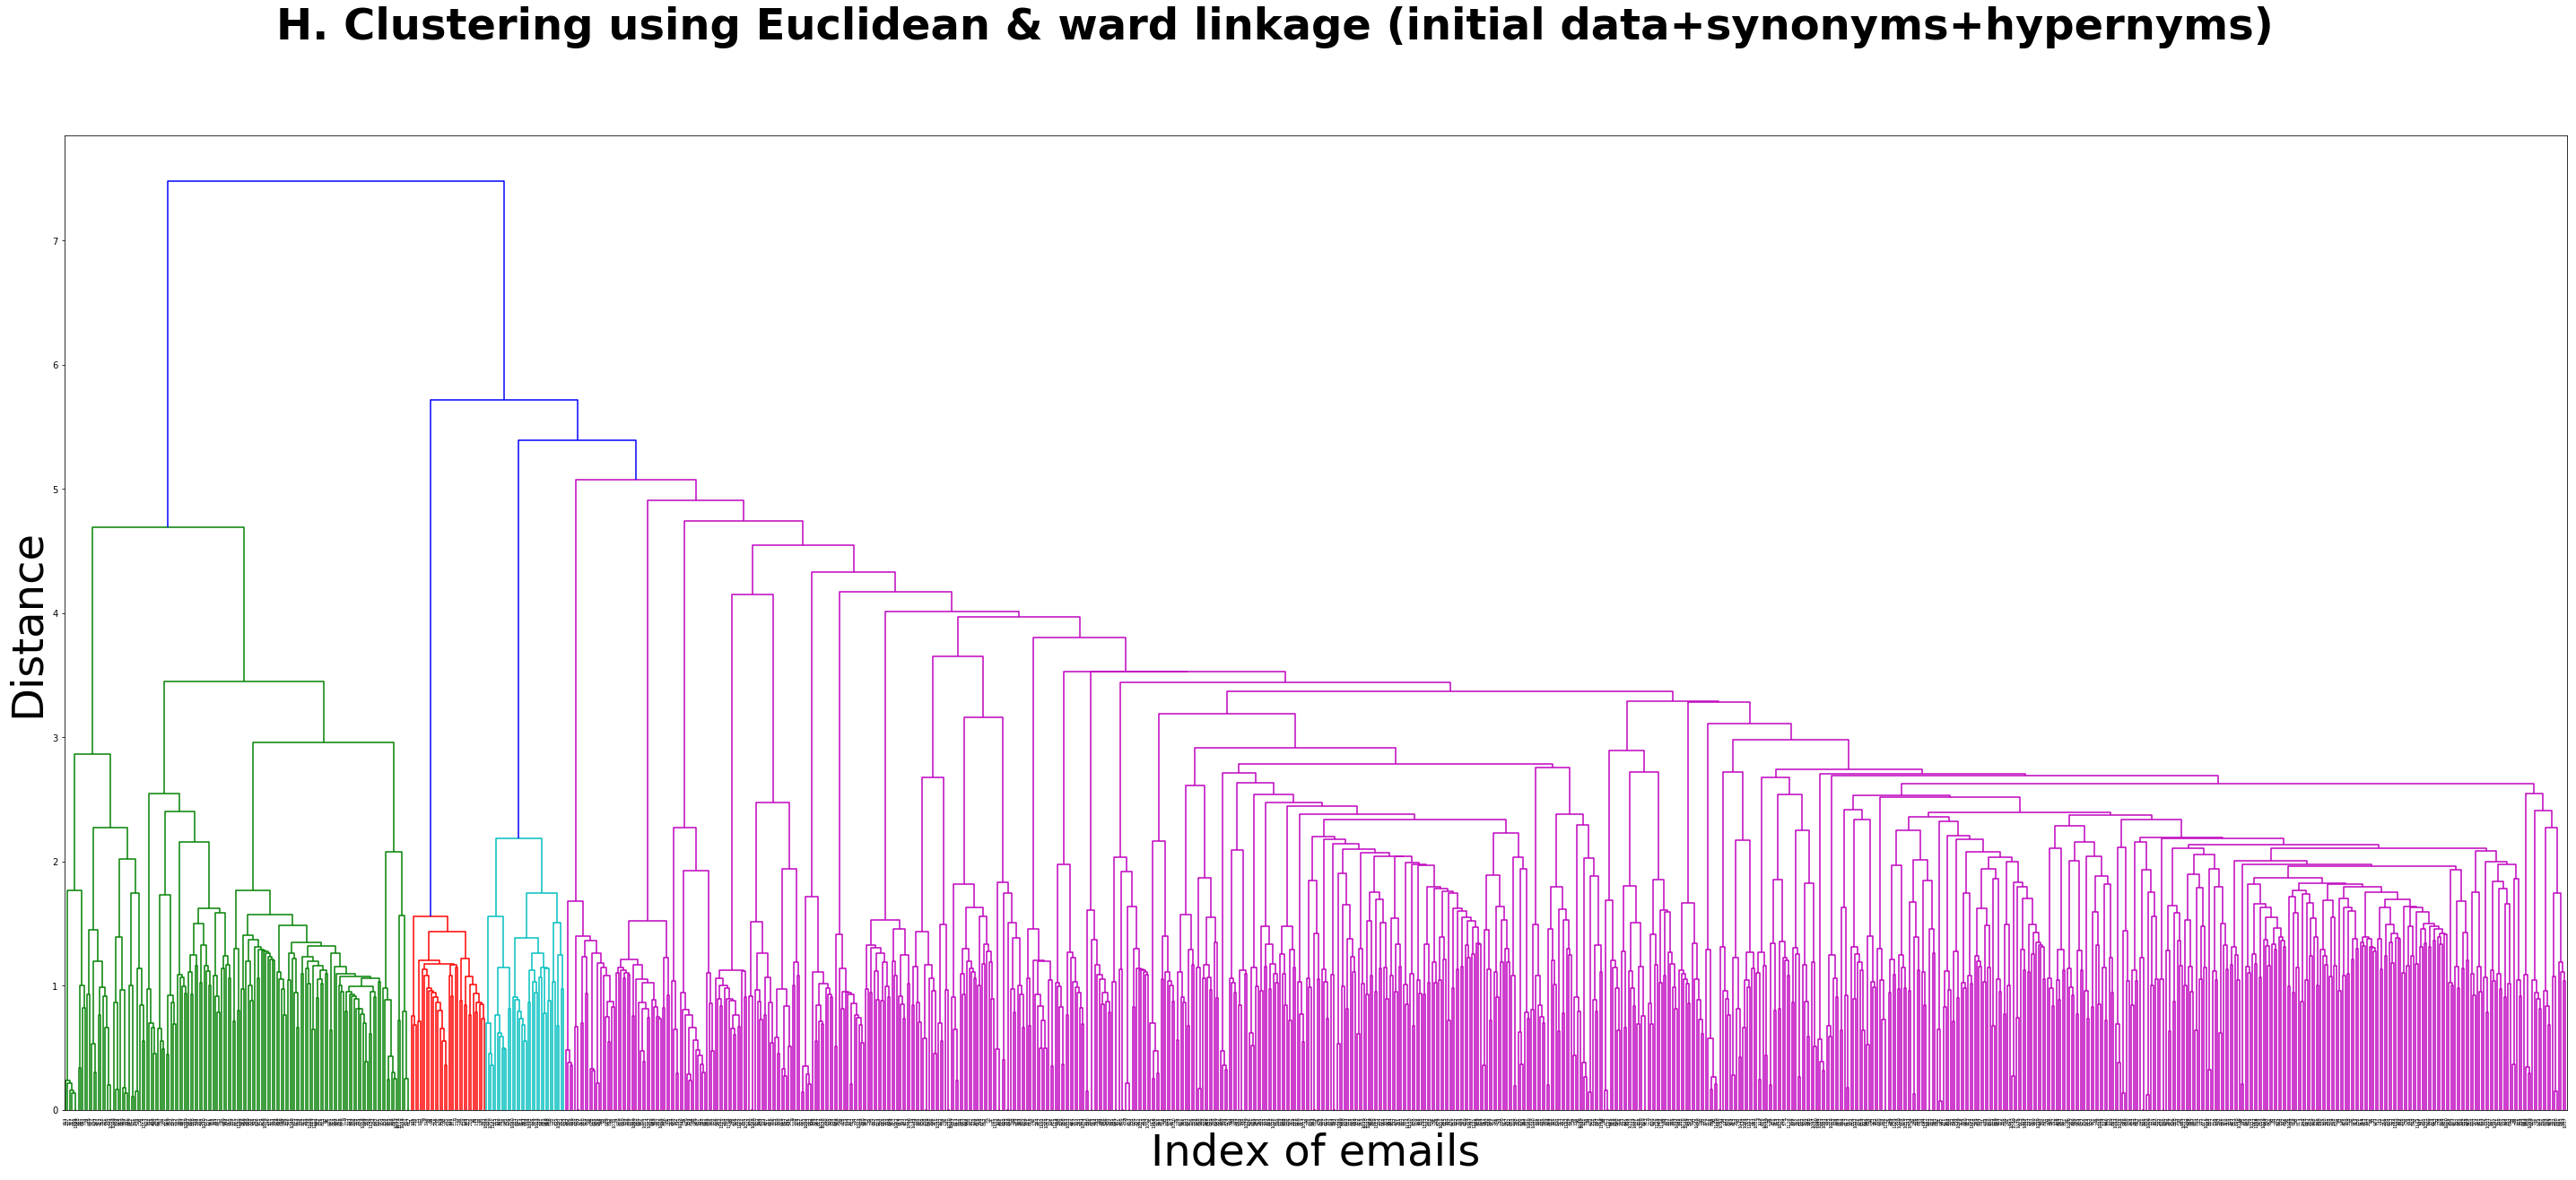

In [8]:
# Setting fugure size
plt.subplots(figsize=(50, 20))

# dend1=dendrogram(data_link)
plt.xlabel('Index of emails', fontsize=48)
plt.ylabel('Distance', fontsize=48)
plt.suptitle('H. Clustering using Euclidean & ward linkage (initial data+synonyms+hypernyms)', fontweight='bold', fontsize=48);
dend1 = sch.dendrogram(sch.linkage(X.todense(), method='ward',  metric='euclidean'))
plt.savefig("../results_dendrograms_kmeans_visualisation/HC1L3.png")

In [9]:
#Reference : http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python
# Particularly for this cell
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">''<td style="background-color: {0}; ''border: 0;">''<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        html += '</table>'
        return html

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    #Extracting Color list and the index coordinates
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    return cluster_classes


#Getting the clusters w.r.t. different colors
get_cluster_classes(dend1)

{'c': ['1010',
  '1131',
  '490',
  '1044',
  '18',
  '961',
  '291',
  '169',
  '197',
  '315',
  '176',
  '274',
  '383',
  '664',
  '814',
  '425',
  '697',
  '223',
  '1080',
  '148',
  '1043',
  '589',
  '1013',
  '325',
  '389',
  '581',
  '881',
  '968',
  '568',
  '806',
  '881',
  '77',
  '352',
  '522',
  '1097',
  '752',
  '804',
  '522'],
 'g': ['936',
  '1124',
  '317',
  '701',
  '237',
  '763',
  '988',
  '991',
  '691',
  '773',
  '29',
  '869',
  '134',
  '517',
  '527',
  '402',
  '417',
  '420',
  '1024',
  '796',
  '221',
  '368',
  '484',
  '578',
  '1098',
  '384',
  '741',
  '999',
  '965',
  '412',
  '571',
  '880',
  '146',
  '579',
  '574',
  '1115',
  '56',
  '741',
  '400',
  '540',
  '185',
  '762',
  '622',
  '42',
  '267',
  '997',
  '603',
  '516',
  '969',
  '299',
  '717',
  '277',
  '362',
  '1069',
  '867',
  '780',
  '535',
  '856',
  '866',
  '643',
  '158',
  '344',
  '261',
  '548',
  '121',
  '551',
  '675',
  '1030',
  '497',
  '557',
  '785',
  '718',
  '10',
  '689',
  '472',
  '950',
  '702',
  '224',
  '471',
  '607',
  '1130',
  '499',
  '966',
  '708',
  '945',
  '889',
  '549',
  '676',
  '971',
  '353',
  '744',
  '101',
  '296',
  '1079',
  '810',
  '179',
  '395',
  '67',
  '934',
  '686',
  '498',
  '908',
  '408',
  '771',
  '513',
  '559',
  '455',
  '1088',
  '776',
  '922',
  '799',
  '1106',
  '233',
  '684',
  '1117',
  '449',
  '562',
  '175',
  '825',
  '87',
  '96',
  '825',
  '921',
  '932',
  '668',
  '876',
  '441',
  '9',
  '775',
  '379',
  '584',
  '1018',
  '624',
  '795',
  '528',
  '326',
  '994',
  '193',
  '396',
  '1134',
  '234',
  '645',
  '521',
  '575',
  '479',
  '914',
  '555',
  '905',
  '896',
  '1063',
  '168',
  '154',
  '329',
  '1073',
  '1110',
  '524',
  '627',
  '507',
  '1058'],
 'm': ['426',
  '899',
  '452',
  '594',
  '634',
  '759',
  '388',
  '311',
  '980',
  '519',
  '726',
  '628',
  '635',
  '66',
  '486',
  '958',
  '669',
  '832',
  '53',
  '86',
  '1071',
  '85',
  '595',
  '74',
  '970',
  '690',
  '704',
  '766',
  '859',
  '608',
  '161',
  '1060',
  '376',
  '1001',
  '447',
  '114',
  '1062',
  '650',
  '992',
  '1005',
  '360',
  '985',
  '849',
  '662',
  '150',
  '886',
  '61',
  '218',
  '742',
  '791',
  '938',
  '264',
  '784',
  '858',
  '600',
  '398',
  '861',
  '391',
  '457',
  '989',
  '68',
  '59',
  '141',
  '1003',
  '345',
  '710',
  '959',
  '361',
  '802',
  '1120',
  '566',
  '286',
  '506',
  '55',
  '262',
  '1103',
  '1104',
  '556',
  '254',
  '306',
  '475',
  '1072',
  '911',
  '930',
  '1048',
  '143',
  '244',
  '434',
  '502',
  '900',
  '122',
  '487',
  '666',
  '706',
  '211',
  '309',
  '760',
  '115',
  '485',
  '582',
  '619',
  '131',
  '542',
  '6',
  '538',
  '728',
  '813',
  '371',
  '585',
  '525',
  '942',
  '1054',
  '769',
  '964',
  '1014',
  '1056',
  '612',
  '349',
  '754',
  '636',
  '790',
  '149',
  '891',
  '928',
  '69',
  '416',
  '167',
  '623',
  '459',
  '680',
  '1023',
  '307',
  '34',
  '144',
  '273',
  '260',
  '303',
  '712',
  '39',
  '720',
  '275',
  '923',
  '947',
  '550',
  '935',
  '793',
  '826',
  '510',
  '410',
  '1052',
  '904',
  '397',
  '403',
  '915',
  '714',
  '113',
  '1096',
  '13',
  '1033',
  '445',
  '462',
  '304',
  '258',
  '629',
  '529',
  '586',
  '711',
  '356',
  '648',
  '162',
  '554',
  '1082',
  '591',
  '1070',
  '76',
  '613',
  '912',
  '657',
  '1095',
  '685',
  '822',
  '534',
  '123',
  '220',
  '442',
  '330',
  '642',
  '616',
  '758',
  '672',
  '857',
  '31',
  '531',
  '2',
  '28',
  '106',
  '432',
  '1123',
  '621',
  '649',
  '385',
  '868',
  '89',
  '399',
  '976',
  '480',
  '872',
  '323',
  '564',
  '451',
  '618',
  '949',
  '212',
  '1102',
  '532',
  '1064',
  '284',
  '170',
  '126',
  '431',
  '713',
  '47',
  '409',
  '956',
  '240',
  '768',
  '1113',
  '553',
  '1012',
  '563',
  '1074',
  '393',
  '327',
  '217',
  '901',
  '207',
  '157',
  '898',
  '336',
  '615',
  '387',
  '948',
  '430',
  '43

In [10]:
#Extracting index of the emails from each class
cluster_index = defaultdict(list)
for c, pi in zip(dend1['color_list'], dend1['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_index[c].append(int(i))

#Creating list of dataframes
list_of_values=[]
for k, v in cluster_index.items():
    list_of_values.append(v)

l_df=[]
for l in list_of_values:
    df_ = pd.concat([pd.DataFrame(l), df_flatlist], axis=1, join='inner')
    l_df.append(df_)


In [11]:
print("Output by Hierarchical clustering\n")
list_l_df=[]

#Counting the number of emails falling in each class
i=0
for l_d in l_df:   
    print("Total Emails in this cluster", i,"=",len(l_d.values.tolist()))
    i+=1
    list_l_df.append(l_d.iloc[:,1:].values.tolist())

Output by Hierarchical clustering

Total Emails in this cluster 0 = 159
Total Emails in this cluster 1 = 34
Total Emails in this cluster 2 = 38
Total Emails in this cluster 3 = 916


In [12]:
def seg_clust(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        for s in pure_string:
            seg.append(segment(s))
    return(seg)
len_listofdf=len(list_l_df)

# LDA on the extracted dataframes

In [13]:
def data_prep_for_lda(i):
    d_comp=[]
    for d in list_l_df[i]:
        d_comp.append(''.join(str(d)))
    seg_cl=seg_clust(d_comp)
    lists_cl=[]
    for s_cl in seg_cl:
        lists_cl.append(' '.join(s_cl))
    return lists_cl

In [14]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    
    #Removing words with length <3
    clean_str=[(re.sub(r'\b\w{1,3}\b', '', doc))]
    
    #Removing Empty elements
    clean_str=list(filter(None, clean_str))
    
    #Removing Stopwords
    stop_free = " ".join([i for i in str(clean_str).lower().split() if i not in stop])
    
    #Removing Punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    
    #for stemming 
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    result = ''.join([i for i in normalized if not i.isdigit()])

    return result

doc_clean=[]
for i in range(0,len(l_df)):
    lists_cl=data_prep_for_lda(i)
    doc_clean.append([clean(doc).split() for doc in list(set(lists_cl))])
    

In [15]:
doc_cleean=list(chain(*doc_clean))

In [16]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_cleean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_cleean]
# doc_term_matrix
dictionary = gensim.corpora.Dictionary(doc_cleean)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in doc_cleean]
# bow_corpus
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=len(l_df), id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.045*"system" + 0.037*"class" + 0.031*"state" + 0.028*"over" + 0.023*"take" + 0.022*"drug" + 0.016*"group" + 0.015*"game" + 0.014*"shop" + 0.014*"ball"
Topic: 1 
Words: 0.042*"ness" + 0.038*"line" + 0.017*"service" + 0.016*"back" + 0.016*"ship" + 0.015*"person" + 0.014*"call" + 0.014*"party" + 0.013*"bush" + 0.012*"good"
Topic: 2 
Words: 0.025*"time" + 0.020*"house" + 0.015*"home" + 0.015*"paper" + 0.014*"order" + 0.014*"work" + 0.012*"aster" + 0.012*"card" + 0.012*"subclass" + 0.011*"computer"
Topic: 3 
Words: 0.028*"down" + 0.024*"rate" + 0.019*"away" + 0.017*"fire" + 0.017*"point" + 0.015*"program" + 0.015*"stock" + 0.015*"right" + 0.014*"school" + 0.014*"board"


In [17]:
# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model.log_perplexity(bow_corpus)
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_cleean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)


 Perplexity of the Spam Classification model:  -6.645612409615966

 Coherence Score of the Spam Classification model:  0.8141185428570564


In [18]:
pyLDAvis.enable_notebook()
id2word=dictionary
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      25.644281        1       1  0.161052  0.247027
0      25.413599        1       2 -0.373105  0.087831
2      24.586973        1       3  0.180950  0.022696
3      24.355141        1       4  0.031103 -0.357553, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
42    Default  304.000000     system  304.000000  30.0000  30.0000
38    Default  290.000000       ness  290.000000  29.0000  29.0000
226   Default  262.000000       line  262.000000  28.0000  28.0000
144   Default  250.000000      class  250.000000  27.0000  27.0000
238   Default  208.000000      state  208.000000  26.0000  26.0000
140   Default  182.000000       down  182.000000  25.0000  25.0000
10    Default  187.000000       over  187.000000  24.0000  24.0000
291   Default  163.000000       time  163.000000  23.0000  23.0000
37    Default  158.000000       rate  158.000000  22.0000  22.0000
380   Default  159.000000       take  159.000000  21.0000  21.0000
202   Default  147.000000       drug  147.000000  20.0000  20.0000
112   Default  132.000000      house  132.000000  19.0000  19.0000
35    Default  123.000000       away  123.000000  18.0000  18.0000
211   Default  118.000000    service  118.000000  17.0000  17.0000
23    Default  112.000000       fire  112.000000  16.0000  16.0000
82    Default  110.000000      point  110.000000  15.0000  15.0000
62    Default  111.000000       back  111.000000  14.0000  14.0000
706   Default  109.000000       ship  109.000000  13.0000  13.0000
136   Default  107.000000      group  107.000000  12.0000  12.0000
2     Default  100.000000    program  100.000000  11.0000  11.0000
643   Default  102.000000     person  102.000000  10.0000  10.0000
398   Default   97.000000      stock   97.000000   9.0000   9.0000
504   Default   97.000000       home   97.000000   8.0000   8.0000
126   Default  100.000000       game  100.000000   7.0000   7.0000
489   Default   97.000000      paper   97.000000   6.0000   6.0000
54    Default   95.000000      right   95.000000   5.0000   5.0000
280   Default   97.000000       shop   97.000000   4.0000   4.0000
246   Default   94.000000     school   94.000000   3.0000   3.0000
133   Default   93.000000      order   93.000000   2.0000   2.0000
621   Default   92.000000      board   92.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
82     Topic4  109.540405      point  110.358170   1.4050  -4.0810
35     Topic4  122.598602       away  123.572197   1.4045  -3.9684
398    Topic4   96.823723      stock   97.597649   1.4045  -4.2044
621    Topic4   91.803734      board   92.551300   1.4043  -4.2577
113    Topic4   88.895363     around   89.666779   1.4038  -4.2898
79     Topic4   89.396454      plant   90.215385   1.4033  -4.2842
2      Topic4   99.334930    program  100.277229   1.4030  -4.1788
246    Topic4   93.362900     school   94.248955   1.4030  -4.2408
99     Topic4   78.714752      white   79.489975   1.4026  -4.4115
54     Topic4   94.497574      right   95.442337   1.4025  -4.2287
484    Topic4   72.142509       sale   72.891449   1.4021  -4.4987
647    Topic4   66.938583       cell   67.686363   1.4013  -4.5735
115    Topic4   68.812416     public   69.594704   1.4011  -4.5459
23     Topic4  111.594795       fire  112.871460   1.4011  -4.0624
32     Topic4   64.122917       well   64.872375   1.4008  -4.6165
98     Topic4   62.673176       book   63.425667   1.4005  -4.6394
558    Topic4   59.033333       ring   59.820717   1.3992  -4.6992
551    Topic4   55.712257      green   56.462139   1.3991  -4.7571
184    Topic4   55.378883      along   56.160400   1.3984  -4.7631
78     Topic4   50.710827      woman   51.475063   1.3975  -4.8512
609    Topic4   49.853245      block   50.606979   1.3974  -4.8682
350    Topic4  

# Version 2
# H. Clustering using Euclidean Distance and Ward linkage


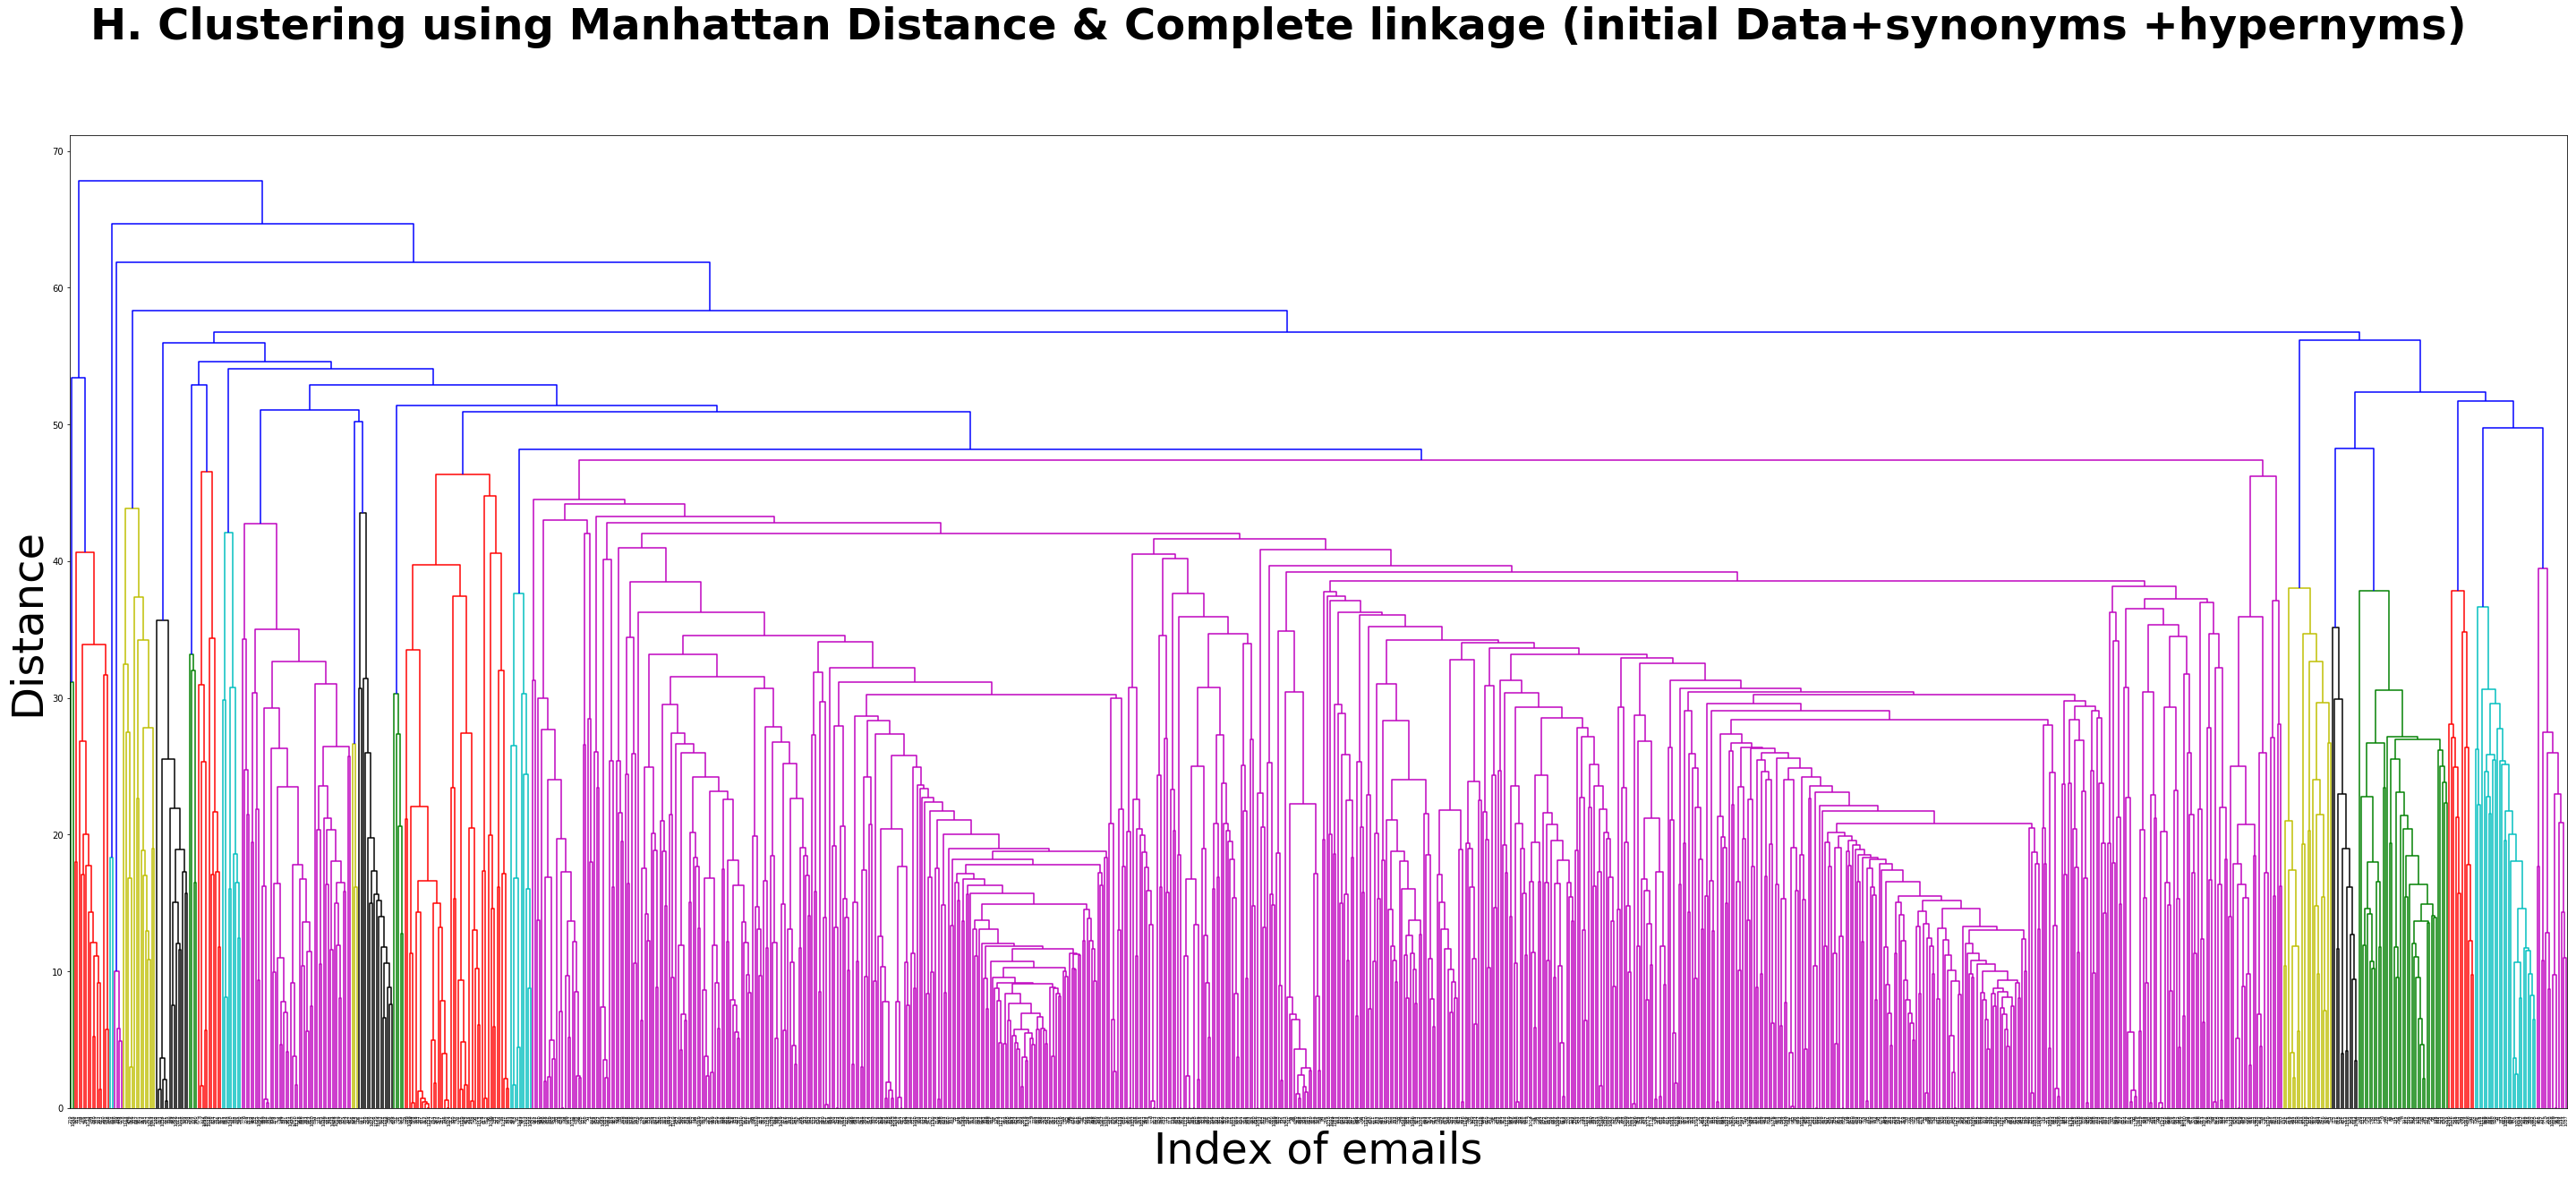

In [19]:
# create dendrogram
plt.subplots(figsize=(50, 20))

plt.xlabel('Index of emails', fontsize=48)
plt.ylabel('Distance', fontsize=48)
plt.suptitle('H. Clustering using Manhattan Distance & Complete linkage (initial Data+synonyms +hypernyms)', fontweight='bold', fontsize=48);
dend2 = sch.dendrogram(sch.linkage(X.todense(), method='complete',  metric='cityblock'))
plt.savefig("../results_dendrograms_kmeans_visualisation/HC2L3.png")

In [20]:
# pd.__version__
get_cluster_classes(dend2)

{'c': ['470',
  '834',
  '817',
  '864',
  '331',
  '709',
  '1040',
  '435',
  '590',
  '338',
  '381',
  '302',
  '413',
  '45',
  '1041',
  '263',
  '138',
  '1084',
  '1107',
  '373',
  '987',
  '61',
  '218',
  '150',
  '766',
  '886',
  '859',
  '608',
  '690',
  '970',
  '662',
  '1060',
  '376',
  '1001',
  '447',
  '114',
  '1062',
  '992',
  '1005',
  '360',
  '985',
  '849',
  '161',
  '650',
  '704',
  '382',
  '74',
  '58',
  '1112'],
 'g': ['209',
  '1045',
  '127',
  '940',
  '518',
  '239',
  '572',
  '937',
  '22',
  '721',
  '604',
  '133',
  '282',
  '43',
  '140',
  '213',
  '73',
  '124',
  '145',
  '16',
  '259',
  '0',
  '64',
  '15',
  '89',
  '195',
  '236',
  '71',
  '191',
  '202',
  '60',
  '245',
  '238',
  '104',
  '72',
  '268',
  '107',
  '227',
  '276',
  '98',
  '198',
  '26',
  '199',
  '4',
  '82',
  '130',
  '215',
  '283',
  '135',
  '182',
  '200',
  '35'],
 'k': ['525',
  '942',
  '371',
  '585',
  '1054',
  '769',
  '964',
  '612',
  '1014',
  '1056',
  '349',
  '754',
  '636',
  '790',
  '149',
  '95',
  '811',
  '566',
  '1072',
  '262',
  '1103',
  '55',
  '286',
  '506',
  '802',
  '1104',
  '1120',
  '556',
  '254',
  '306',
  '911',
  '451',
  '618',
  '126',
  '431',
  '212',
  '1102',
  '532',
  '1064',
  '284',
  '170',
  '713',
  '47'],
 'm': ['448',
  '874',
  '749',
  '996',
  '728',
  '813',
  '6',
  '538',
  '519',
  '726',
  '522',
  '1097',
  '752',
  '384',
  '741',
  '999',
  '965',
  '176',
  '274',
  '18',
  '169',
  '291',
  '961',
  '197',
  '315',
  '1010',
  '1131',
  '490',
  '1044',
  '806',
  '881',
  '383',
  '664',
  '814',
  '1080',
  '968',
  '383',
  '949',
  '223',
  '425',
  '77',
  '389',
  '581',
  '148',
  '1043',
  '589',
  '697',
  '1013',
  '568',
  '325',
  '804',
  '1036',
  '204',
  '481',
  '833',
  '751',
  '953',
  '311',
  '980',
  '486',
  '958',
  '452',
  '899',
  '426',
  '594',
  '634',
  '759',
  '388',
  '669',
  '832',
  '53',
  '66',
  '628',
  '635',
  '86',
  '1071',
  '85',
  '452',
  '595',
  '171',
  '280',
  '1',
  '845',
  '50',
  '456',
  '877',
  '515',
  '653',
  '1061',
  '1083',
  '246',
  '705',
  '967',
  '954',
  '84',
  '369',
  '394',
  '750',
  '458',
  '838',
  '639',
  '476',
  '587',
  '878',
  '75',
  '229',
  '351',
  '755',
  '601',
  '847',
  '902',
  '354',
  '226',
  '362',
  '867',
  '535',
  '780',
  '1073',
  '1110',
  '689',
  '400',
  '540',
  '185',
  '762',
  '622',
  '548',
  '950',
  '472',
  '1069',
  '10',
  '702',
  '42',
  '267',
  '997',
  '603',
  '516',
  '969',
  '299',
  '717',
  '277',
  '158',
  '386',
  '261',
  '866',
  '497',
  '557',
  '785',
  '718',
  '408',
  '121',
  '551',
  '856',
  '675',
  '1030',
  '344',
  '119',
  '467',
  '1020',
  '844',
  '93',
  '305',
  '1114',
  '862',
  '539',
  '746',
  '892',
  '1059',
  '740',
  '703',
  '816',
  '1029',
  '541',
  '665',
  '836',
  '343',
  '415',
  '51',
  '301',
  '469',
  '592',
  '797',
  '626',
  '172',
  '347',
  '225',
  '520',
  '573',
  '412',
  '571',
  '880',
  '433',
  '493',
  '370',
  '499',
  '421',
  '530',
  '1025',
  '918',
  '865',
  '988',
  '991',
  '691',
  '773',
  '427',
  '984',
  '588',
  '972',
  '414',
  '644',
  '380',
  '747',
  '555',
  '905',
  '896',
  '1063',
  '168',
  '154',
  '508',
  '329',
  '524',
  '627',
  '507',
  '1058',
  '139',
  '897',
  '232',
  '731',
  '1050',
  '294',
  '224',
  '471',
  '607',
  '1130',
  '110',
  '598',
  '179',
  '673',
  '882',
  '688',
  '101',
  '422',
  '11',
  '873',
  '36',
  '455',
  '1088',
  '293',
  '296',
  '776',
  '922',
  '353',
  '708',
  '889',
  '945',
  '684',
  '1117',
  '175',
  '67',
  '513',
  '559',
  '668',
  '876',
  '624',
  '795',
  '934',
  '193',
  '379',
  '584',
  '1018',
  '1134',
  '9',
  '775',
  '528',
  '449',
  '994',
  '234',
  '645',
  '326',
  '396',
  '379',
  '921',
  '932',
  '575',
  '1106',
  '521',
  '479',
  '441',
  '87',
  '562',
  '825',
  '829',
  '676',
  '771',
  '799',
  '656',
  '966',
  '96',
  '914',


In [21]:
cluster_idxs_1 = defaultdict(list)
for c, pi in zip(dend2['color_list'], dend2['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs_1[c].append(int(i))


#Creating list of dataframes
list_of_values1=[]
for k, v in cluster_idxs_1.items():
    list_of_values1.append(v)

l_df1=[]
for l1 in list_of_values1:
    df_1 = pd.concat([pd.DataFrame(l1), data_subset], axis=1, join='inner')
    l_df1.append(df_1)


In [22]:
#Extracting Emails from each cluster
def emails_in_cluster(clust_list):
    
    clust_list.sort()
    clust_df=pd.DataFrame(clust_list)

    result = pd.concat([clust_df, data_subset], axis=1, join='inner')    
    return result

returned_spams=[]
for k, v in cluster_idxs_1.items():
    returned_spams.append(emails_in_cluster(v))

In [23]:
#Depending on the number of clusters returned, fetching the corresponding groups of emails and storing them in seperate files.
for i in range (0,len(returned_spams)):
    pd.DataFrame(returned_spams[i]).to_csv("../exported_tables/Returned_Spams_cluster"+str(i)+".csv")
    


In [24]:

print("Output by Hierarchical clustering\n")
list_l_df1=[]

i=0
for l_d in l_df1:
   
    print("Total Emails in this cluster", i,"=",len(l_d.values.tolist()))
    i+=1
    list_l_df1.append(l_d.iloc[:,1:].values.tolist())

Output by Hierarchical clustering

Total Emails in this cluster 0 = 52
Total Emails in this cluster 1 = 87
Total Emails in this cluster 2 = 49
Total Emails in this cluster 3 = 869
Total Emails in this cluster 4 = 40
Total Emails in this cluster 5 = 43


In [25]:
def data_prep2_for_lda(i):
    d_comp=[]
    for d in list_l_df1[i]:
        d_comp.append(''.join(str(d)))
    seg_cl=seg_clust(d_comp)
    lists_cl=[]
    for s_cl in seg_cl:
        lists_cl.append(' '.join(s_cl))
    return lists_cl

In [26]:
len_listofdf=len(list_l_df1)
doc_clean1=[]

for i in range(0,len(l_df1)):
    lists_cl1=data_prep2_for_lda(i)
    doc_clean1.append([clean(doc).split() for doc in list(set(lists_cl1))])
    

doc_cleean1=list(chain(*doc_clean1))

In [27]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary1 = corpora.Dictionary(doc_cleean1)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix1 = [dictionary1.doc2bow(doc) for doc in doc_cleean1]
# doc_term_matrix
dictionary1 = gensim.corpora.Dictionary(doc_cleean1)

bow_corpus1 = [dictionary1.doc2bow(doc) for doc in doc_cleean1]
# bow_corpus
lda_model1 = gensim.models.LdaMulticore(bow_corpus1, num_topics=len(l_df1), id2word=dictionary1, passes=2, workers=2)

for idx, topic in lda_model1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"mail" + 0.015*"viagra" + 0.013*"trusted" + 0.012*"mailcom" + 0.011*"pfizer" + 0.010*"this" + 0.008*"qyjrijzi" + 0.007*"facebook" + 0.007*"user" + 0.007*"suddenly"
Topic: 1 
Words: 0.018*"store" + 0.014*"personal" + 0.011*"speed" + 0.011*"viagra" + 0.009*"delivery" + 0.009*"right" + 0.009*"mail" + 0.008*"upgrade" + 0.008*"zapp" + 0.008*"vera"
Topic: 2 
Words: 0.017*"sale" + 0.015*"system" + 0.015*"info" + 0.014*"body" + 0.014*"swreg" + 0.014*"compro" + 0.014*"mining" + 0.013*"style" + 0.009*"lora" + 0.009*"client"
Topic: 3 
Words: 0.016*"notification" + 0.016*"john" + 0.014*"price" + 0.011*"link" + 0.011*"march" + 0.010*"rate" + 0.010*"down" + 0.009*"europe" + 0.009*"marketing" + 0.008*"life"
Topic: 4 
Words: 0.016*"diskeeper" + 0.013*"julian" + 0.012*"service" + 0.012*"yahoo" + 0.010*"best" + 0.010*"great" + 0.009*"discount" + 0.009*"saturday" + 0.009*"ralph" + 0.008*"cable"
Topic: 5 
Words: 0.019*"viagra" + 0.009*"friend" + 0.009*"cannon" + 0.009*"borges" + 0.0

In [28]:
# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model1.log_perplexity(bow_corpus1)

print("(using synonyms and hypernyms)")
print()
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=lda_model1, texts=doc_cleean1, dictionary=dictionary1, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)

(using synonyms and hypernyms)


 Perplexity of the Spam Classification model:  -9.048171450858938

 Coherence Score of the Spam Classification model:  0.8141185428570564


In [29]:
pyLDAvis.enable_notebook()
id2word=dictionary1
vis = pyLDAvis.gensim.prepare(lda_model1, bow_corpus1, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      17.419914        1       1 -0.168765  0.102260
2      17.037401        1       2  0.164516  0.125184
0      16.927107        1       3 -0.003842 -0.042980
4      16.756912        1       4  0.029602 -0.168702
5      16.193251        1       5 -0.060729 -0.021112
3      15.665410        1       6  0.039219  0.005351, topic_info=     Category       Freq          Term      Total  loglift  logprob
term                                                               
38    Default  14.000000          sale  14.000000  30.0000  30.0000
33    Default  37.000000        viagra  37.000000  29.0000  29.0000
15    Default  12.000000          john  12.000000  28.0000  28.0000
174   Default  12.000000        system  12.000000  27.0000  27.0000
92    Default  18.000000         store  18.000000  26.0000  26.0000
145   Default  15.000000     diskeeper  15.000000  25.0000  25.0000
59    Default  13.000000  notification  13.000000  24.0000  24.0000
164   Default  12.000000          body  12.000000  23.0000  23.0000
34    Default  11.000000        compro  11.000000  22.0000  22.0000
165   Default  11.000000        mining  11.000000  21.0000  21.0000
22    Default  12.000000      personal  12.000000  20.0000  20.0000
36    Default  13.000000         swreg  13.000000  19.0000  19.0000
30    Default  11.000000        julian  11.000000  18.0000  18.0000
62    Default  36.000000          mail  36.000000  17.0000  17.0000
28    Default  11.000000         style  11.000000  16.0000  16.0000
152   Default  10.000000       service  10.000000  15.0000  15.0000
140   Default  15.000000          info  15.000000  14.0000  14.0000
82    Default   9.000000         yahoo   9.000000  13.0000  13.0000
130   Default  12.000000         price  12.000000  12.0000  12.0000
101   Default  11.000000       trusted  11.000000  11.0000  11.0000
143   Default  12.000000       mailcom  12.000000  10.0000  10.0000
245   Default   9.000000          link   9.000000   9.0000   9.0000
238   Default   8.000000         march   8.000000   8.0000   8.0000
157   Default  10.000000         speed  10.000000   7.0000   7.0000
175   Default   8.000000          this   8.000000   6.0000   6.0000
253   Default   8.000000          rate   8.000000   5.0000   5.0000
207   Default   7.000000      discount   7.000000   4.0000   4.0000
267   Default   7.000000          lora   7.000000   3.0000   3.0000
156   Default   7.000000      delivery   7.000000   2.0000   2.0000
95    Default   7.000000         right   7.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
94     Topic6   6.258464     marketing   7.120687   1.7246  -4.7664
167    Topic6   3.685397         woman   4.244271   1.7125  -5.2959
154    Topic6   5.572918          from   6.426580   1.7112  -4.8824
263    Topic6   7.101733          down   8.278090   1.7004  -4.6400
59     Topic6  11.917846  notification  13.933649   1.6974  -4.1223
317    Topic6   3.011603          than   3.567688   1.6843  -5.4978
382    Topic6   3.009996    investment   3.567491   1.6838  -5.4984
191    Topic6   5.679039     excitecom   6.742257   1.6821  -4.8635
153    Topic6   5.333733       tuesday   6.403153   1.6710  -4.9262
253    Topic6   7.448165          rate   8.953547   1.6696  -4.5923
1600   Topic6   2.674679       olympia   3.229365   1.6653  -5.6165
462    Topic6   2.673981        israel   3.229299   1.6650  -5.6167
347    Topic6   2.673211         kathy   3.229202   1.6648  -5.6170
130    Topic6   9.937592         price  12.099913   1.6568  -4.3040
47     Topic6   5.223309    discounted   6.391291   1.6519  -4.9472
836    Topic6   2.903461        report   3.553297   1.6517  -5.5344
2389   Topic6   2.339636         galla   2.891254   1.6420  -5.7503
2390   Topic6   2.339583       killian   2.891250   1.6420  -5.7503
2378   Topic6   2.339523          pile   2.891249   1.642